Anthony BERNARD, Junyi Li

<h1><center>FTML Project Report</center></h1>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

## 1 bayes estimator and bayes risk

### Q1

On choisit les paramètres suivants :
$$
\begin{aligned}
\mathcal{X} & =\{1, 2, 3\} \\
\mathcal{Y} & =\{0, 1\}
\end{aligned}
$$
$X$ suit une loi uniforme sur $\mathcal{X}$
$$
Y=\left\{\begin{array}{l}
Q(1 / 4) \text { if } X=1 \\
Q(2 / 5) \text { if } X=2 \\
Q(3 / 4) \text { if } X=3
\end{array}\right.
$$
Avec $Q(p)$ un loi de paramètre $p$, telle que :
$$
P(X=x)=\left\{\begin{array}{l}
p \text { if } x=0 \\
1-p \text { if } x=1 \\
0 \text { else }
\end{array}\right.
$$

On choisit la "0-1" loss $l(y, z)=1_{y \neq z}$.  
L'estimateur de Bayes est défini par :
$$
f^*(x)=\arg \min E[l(y, z) \mid X=x]
$$
Ainsi :
$$
\begin{aligned}
f^*(x) & =\arg \min E[l(y, z) \mid X=x] \\
& =\arg \min P(Y \neq z \mid X=x) \\
& =1-\arg \min P(Y=z \mid X=x) \\
& =\arg \max P(Y=z \mid X=x)
\end{aligned}
$$
On obtient:
\begin{aligned}
-f^*(1) & =1 \\
-f^*(2) & =1 \\
-f^*(3) & =0
\end{aligned}

On va calculer le risque de Bayes :
$$
\begin{aligned}
R^*(x) & =E\left[l\left(Y, f^*(X)\right)\right] \\
& =E_X\left[E_Y\left(l\left(Y \neq f^*(X) \mid X\right)\right)\right] \\
& =E_X\left[P\left(Y \neq f^*(X) \mid X\right)\right]
\end{aligned}
$$
Sachant que :
$$
P\left(Y \neq f^*(X) \mid X=x\right)=P\left(Y \neq f^*(x)\right)
$$
On note $\eta(x)=P(Y=0 \mid X=x)$. Then :
- Si $\eta(x)>\frac{1}{2}$, alors $f^*(x)=0$, et $P\left(Y \neq f^*(x)\right)=P(Y=1)=1-\eta(x)$
- Si $\eta(x)<\frac{1}{2}$, alors $f^*(x)=1$, et $P\left(Y \neq f^*(x)\right)=P(Y=0)=\eta(x)$  
ON obtient, $P\left(Y \neq f^*(x)\right)=\min (\eta(x), 1-\eta(x))$.  
Donc
$$
R^*=E_X[\min (\eta(X), 1-\eta(X)]
$$

On applique :
$$
\begin{aligned}
R^* & =\frac{1}{3} *\frac{1}{4}+\frac{1}{3} *\frac{2}{5}+\frac{1}{3} *\frac{1}{4} \\
R^* & =\frac{3}{10}
\end{aligned}
$$

### Q2

d: 1
plot
d: 1


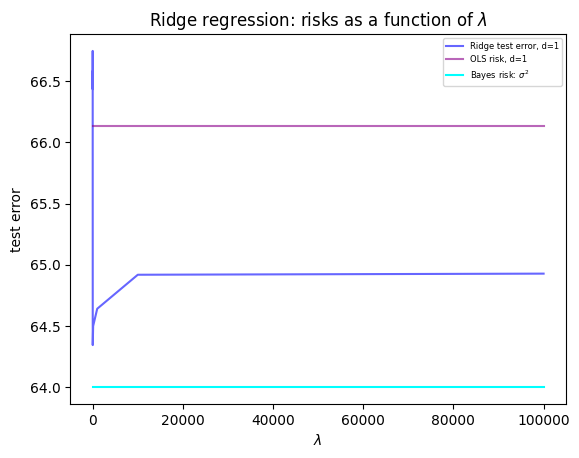

In [2]:
SIGMA = 8
BAYES_RISK = SIGMA**2

def generate_output_data(
    X: np.ndarray, theta_star, sigma: float, rng, n_tests: int
) -> np.ndarray:
    """
    generate input and output data (supervised learning)
    according to the linear model, fixed design setup
    - X is fixed
    - y is random, according to

    Y = Xtheta_star + epsilon

    We use numpy matrix manipulations in order
    to directly generate a number of output vectors.

    where epsilon is a centered gaussian noise vector with variance
    sigma*In

    Parameters:
        X: (n, d) design matrix
        theta_star
        sigma (float): variance of the noise

    Returns:
        Y (float matrix): output vector (n, 1)
    """
    n = X.shape[0]
    noise = rng.normal(0, sigma, size=(n, n_tests))
    y = theta_star(X) + noise
    return y

def ridge_regression_estimator(
    X: np.ndarray, y: np.ndarray, lambda_: float
) -> np.ndarray:
    """
    Compute the Ridge regression estimator

    We use numpy broadcasting to accelerate computations
    and obtain several Ridge estimators.

    Parameters:
        X: (n, d) matrix
        y: (n, n_tests) matrix
        lambda: regularization parameter

    Returns:
        theta_hat: (d, n_tests) matrix
    """
    n, d = X.shape
    covariance_matrix = X.T @ X
    Sigma_matrix = covariance_matrix / n
    theta_hat = 1 / n * np.linalg.inv(Sigma_matrix + lambda_ * np.identity(d)) @ X.T @ y
    return theta_hat

def q_law(x, p):
    return p if x == 0 else (1 - p if x == 1 else 0)

def bayes_predictor(x):
    if x == 1:
        return 0 if q_law(0, 1/4) > q_law(1, 1/4) else 1
    if x == 2:
        return 0 if q_law(0, 2/5) > q_law(1, 2/5) else 1
    if x == 3:
        return 0 if q_law(0, 3/4) > q_law(1, 3/4) else 1
    
def ridge_risk(n, d, lambda_, n_tests) -> tuple[float, float]:
    """
    Statistical evaluation of the excess risk of the Ridge regression
    estimator

    n_test times, do:
        - Draw output vector Y, according to the linear model, fixed
        design setup.
        - compute the corresponding Ridge estimator
        - generate a test test in order to have an estimation of the excess risk of
        this estimator (generalization error)

    Parameters:
        n (int): number of samples in the dataset
        d (int): dimension of each sample (number of features)
        n_tests (int): number of simulations run

    Returns:
        risk_estimation (float): estimation of the excess risk of the ridge
        estimator in this setup.
    """
    # instantiate a PRNG
    rng = np.random.default_rng()

    # design matrix
    X = np.array([[rng.choice([1, 2, 3]) for _ in range(d)] for _ in range(n)])

    # Bayes predictor
    theta_star = np.vectorize(bayes_predictor)

    # run several simulations to have an estimation of the excess risk
    y = generate_output_data(X, theta_star, SIGMA, rng, n_tests)

    # compute the Ridge regression estimator
    theta_hat = ridge_regression_estimator(X, y, lambda_)

    # generate test data
    y_test = generate_output_data(X, theta_star, SIGMA, rng, n_tests)

    # compute predictions of each OLS estimator
    y_pred = X @ theta_hat

    mean_test_error = np.linalg.norm(y_pred - y_test) ** 2 / (n * n_tests)

    return mean_test_error

def plot_test_errors_ridge(
    risks: dict[tuple, float], d_list: list[int], n: int, lambda_list: list[int]
) -> None:
    """
    Display all the computed risks on a plot
    """
    colors = ["blue", "green", "darkred", "mediumvioletred", "darkmagenta"]
    index = 0
    print("plot")

    # plot the risks for each n and d
    for index, d in enumerate(d_list):
        print(f"d: {d}")
        color = colors[index]
        risk_estimates = [risks[d, lambda_] for lambda_ in lambda_list]
        ols_risk = BAYES_RISK + SIGMA**2 * d / n
        alpha = 0.6
        # extended label for the first ont
        label_est = f"Ridge test error, d={d}"
        label_ols = f"OLS risk, d={d}"
        plt.plot(
            lambda_list,
            risk_estimates,
            label=label_est,
            color=color,
            markersize=3,
            alpha=alpha,
        )
        plt.plot(
            lambda_list,
            [ols_risk] * len(lambda_list),
            label=label_ols,
            color="darkmagenta",
            alpha=alpha,
        )

    plt.plot(
        lambda_list,
        [BAYES_RISK] * len(lambda_list),
        label="Bayes risk: " + r"$\sigma^2$",
        color="aqua",
    )

    # finish plot
    plt.xlabel(r"$\lambda$")
    plt.ylabel("test error")
    plt.title(
        "Ridge regression: risks as a function of " + r"$\lambda$"
    )
    plt.legend(loc="best", fontsize=6)

# dimensions of the problem
n_list = [30]
n = 30
# d_list = list(range(0, 1000, 200))
# d_list.remove(0)
d_list = [1]
bayes_risk = 3/10

exponents = [k for k in range(-6, 6)]
lambda_list = [10 ** (u) for u in exponents]

# number of tests to estimate the excess risk
n_tests = int(1e4)

# Assess the influence of different values of n and d
test_errors = dict()
for d in d_list:
    print(f"d: {d}")
    for lambda_ in lambda_list:
        # print(f"lambda: {lambda_}")
        for n in n_list:
            test_errors[(d, lambda_)] = ridge_risk(n, d, lambda_, n_tests)
plot_test_errors_ridge(test_errors, d_list, 30, lambda_list)

The generalization error is smaller for $f^*$ than for $\tilde{f}$

## 2 bayes risk with absolute loss

### Q1

$\mathrm{P}(\mathrm{Y} \mid \mathrm{X}=\mathrm{x})$ where $\mathrm{Y} \mid \mathrm{X}=\mathrm{x}$ correspond à une distribution continue $\operatorname{Exp}(\lambda)$.  
L'estimateur de Bayes pour la $l_2$ squared loss
$$
f_2^*(x)=E[Y \mid X=x]=E\left[\lambda e^{-\lambda}\right]=\frac{1}{\lambda}
$$
L'estimateur de Bayes pour la $l_1$ absolute loss est la médiane de $\mathrm{Y} \mid \mathrm{X}=\mathrm{x}$
$$
f_1^*(x)=\frac{\ln (2)}{\lambda}
$$
ON a bien 2 estimateurs différents

### Q2

On note $p=\mathrm{P}(\mathrm{Y} \mid \mathrm{X}=\mathrm{x})$
$$
\begin{gathered}
g(z)=\int_{\mathbb{R}}|y-z| p(y) d y \\
=\int_z^{+\infty} y p(y) d y-z \int_z^{+\infty} p(y) d y+z \int_{-\infty}^z p(y) d y-\int_{-\infty}^z y p(y) d y \\
\frac{d}{d z} g(z)=-z p(z)-\left(\int_z^{+\infty} p(y) d y-z p(z)\right)+\left(\int_{-\infty}^z p(y) d y+z p(z)\right)-z p(z) \\
=\int_{-\infty}^z p(y) d y-\int_z^{+\infty} p(y) d y
\end{gathered}
$$
On obtient, $\frac{d}{d z} g(z)=0$ si :
$$
\int_{-\infty}^z p(y) d y=\int_z^{+\infty} p(y) d y
$$
On a ce résultat, si on trouve $\frac{1}{2}$ des deux côtés, donc l'estmiateur de Bayes $f^*(x)$ est la médianne.  
On va confirmé qu'il sagit d'un minimum de $\mathrm{g}(\mathrm{z})$, dérivée seconde:
$$
\frac{d^2}{d z^2} g(z)=2 p(z)>0
$$
Elle est positive donc on a un minimum.

## 3 expected value of empirical risk for ols

### Q1

On veut montrer que $\mathbb{E}\left(R_n(\hat{\theta})\right)=\mathbb{E}_\epsilon\left(\frac{1}{n}\left\|\left(I_n-X\left(X^T X\right)^{-1} X^T\right) \epsilon\right\|^2\right)$  
Or $R_n(\hat{\theta})=\frac{1}{n}\|Y-X \hat{\theta}\|^2$ et $\hat{\theta}=\left(X^T X\right)^{-1} X^T Y$ et $Y=X \theta^*+\epsilon$  
Donc:
$$  
\begin{aligned}
R_n(\hat{\theta}) & =\frac{1}{n}\left\|X \theta^*+\epsilon-X\left(X^T X\right)^{-1} X^T\left(X \theta^*+\epsilon\right)\right\|^2 \\
& =\frac{1}{n}\left\|X \theta^*+\epsilon-X\left(X^T X\right)^{-1} X^T X \theta^*+X\left(X^T X\right)^{-1} X^T \epsilon\right\|^2 \\
& =\frac{1}{n}\left\|\epsilon\left(I_n-X\left(X^T X\right)^{-1} X^T\right)\right\|^2
\end{aligned}
$$
Donc $\mathbb{E}\left(R_n(\hat{\theta})\right)=\mathbb{E}_\epsilon\left(\frac{1}{n}\left\|\left(I_n-X\left(X^T X\right)^{-1} X^T\right) \epsilon\right\|^2\right)$

### Q2

$$
\begin{gathered}
A \in \mathbb{R}^{n, m} B \in \mathbb{R}^{n, m} \\
\operatorname{tr}\left(A^T B\right)=\sum_{i, j \in[1, n] \times[1, m]} a_{i j} b_{i j}
\end{gathered}
$$
ON en conclut::
$$
\begin{aligned}
A & \in \mathbb{R}^{n, n} \\
\operatorname{tr}\left(A^T A\right) & =\sum_{i, j} a_{i j} a_{i j}
\end{aligned}
$$

### Q3

$\begin{aligned}E\left[\frac{1}{n}\|A \varepsilon\|^2\right] & =E\left[\frac{1}{n} \sum_{i=1}^n\left(A_i \varepsilon\right)^2\right] \\ 
& =E\left[\frac{1}{n} \sum_{i=1}^n\left(\varepsilon^T A_i^T\right)^2\right] \\ 
& =E\left[\frac{1}{n} \sum_{i=1}^n\left(\varepsilon^T A_i^T A_i \varepsilon\right)\right] \\ 
& =E\left[\frac{1}{n} \sum_{i=1}^n\left(\varepsilon^T \varepsilon A_i^T A_i\right)\right] \\ 
& =E\left[\frac{1}{n} \varepsilon^T \varepsilon \sum_{i=1}^n\left(A_i^T A_i\right)\right] \\ 
& =E\left[\frac{1}{n} \varepsilon^2 \sum_{(i j) \in[1, n]^2}\left(A_{i j}^2\right)\right] \\ 
& =\frac{\sigma^2}{n} \operatorname{Tr}\left(A^T A\right)\end{aligned}$

### Q4

$\begin{gathered}A^t A=I_n-2 I_n X\left(X^t X\right)^{-1} X^t+X\left(X^t X\right)^{-1} X^t X\left(X^t X\right)^{-1} X^t \\ A^t A=I_n-2 X\left(X^t X\right)^{-1} X^t+X\left(X^t X\right)^{-1} X^t \\ 
A^t A=I_n-X\left(X^t X\right)^{-1} X^t \\ 
A^t A=A\end{gathered}$


### Q5

$$
\begin{gathered}
E\left[R_n(\hat{\theta})\right]=E_\epsilon\left[\frac{1}{n}\left\|\left(I_n-X\left(X^T X\right)^{-1} X^T\right) \epsilon\right\|_2^2\right] \\
=\frac{\sigma^2}{n} \operatorname{tr}\left(I_n-X\left(X^T X\right)^{-1} X^T\right) \\
=\frac{\sigma^2}{n}\left(n-\operatorname{tr}\left(X\left(X^T X\right)^{-1} X^T\right)\right) \\
=\frac{\sigma^2}{n}\left(n-\operatorname{tr}\left(X^T X\left(X^T X\right)^{-1}\right)\right) \\
=\frac{\sigma^2}{n}\left(n-\operatorname{tr}\left(I_d\right)\right) \\
=\frac{\sigma^2}{n}(n-d)
\end{gathered}
$$
Ainsi:
$$
E\left[R_X(\hat{\theta})\right]=E\left[E\left[R_n(\hat{\theta})\right]\right]=E\left[\frac{n-d}{n} \sigma^2\right]=\frac{n-d}{n} \sigma^2
$$

### Q6

On obtient:  
$$
\frac{\|y-\widehat{\theta}\|}{n-d} \sigma^2=\frac{n-d}{n-d} \sigma^2=\sigma^2
$$

In [3]:
rng = np.random.RandomState(23)
d = 23
sigma = 0.25
n = 5000
theta = rng.rand(d).reshape(d, 1)

X = rng.rand(n, d)
epsilon = rng.normal(0, sigma, size=(n, 1))
y = X @ theta + epsilon
theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

sigma_estimator = np.linalg.norm(y - X @ theta_hat) ** 2 / (n - d)
print("Sigma value is {}",format(float(sigma**2)))
print("Sigma estimator is {}",format(float(sigma_estimator)))

Sigma value is {} 0.0625
Sigma estimator is {} 0.06099973573401494


On a bien un résultat cohérent

### Q4

X_train correspond à un tableau 100x100 et y_train aux valeurs correspondantes.  
On voit que les données dans X_train sont déjà normalisées.

### Load data

In [4]:
import data
import numpy as np
import matplotlib.pyplot as plt

X_train = np.load('data/regression/X_train.npy')
y_train = np.load('data/regression/y_train.npy')
X_test = np.load('data/regression/X_test.npy')
y_test = np.load('data/regression/y_test.npy')

### Régression avec ou sans Cross Validation

 Les données semblent centrées donc on a set fit_intercept = False.

Lasso Sans GridSearchCV:  -6.2890074371080535
Lasso Avec GridSearchCV:  0.8988476972984797
Best hyperparameters: {'alpha': 0.011188722115874222}


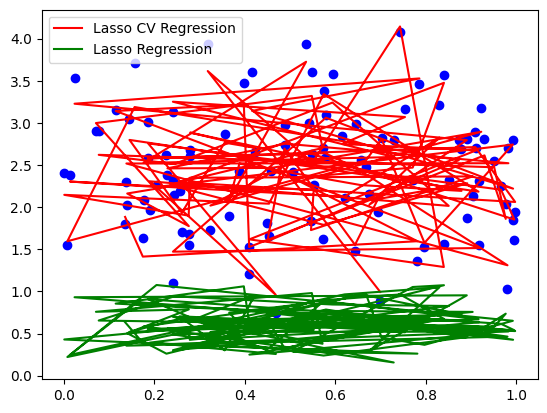

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
import os

clf = Lasso(fit_intercept=False).fit(X_train, y_train)
y_pred_lasso = clf.predict(X_test)
print("Lasso Sans GridSearchCV: ", r2_score(y_test, y_pred_lasso))

clf_CV = GridSearchCV(Lasso(fit_intercept=False), {'alpha': np.logspace(-2, 0, 42)}).fit(X_train, y_train)
y_pred_lasso_cv = clf_CV.predict(X_test)
print("Lasso Avec GridSearchCV: ", r2_score(y_test, y_pred_lasso_cv))
print(f'Best hyperparameters: {clf_CV.best_params_}')

# Plot the data and the predictions
plt.scatter(X_test[:, 0], y_test, color='b')
plt.plot(X_test[:, 0], y_pred_lasso_cv, color='r', label='Lasso CV Regression')
plt.plot(X_test[:, 0], y_pred_lasso, color='g', label='Lasso Regression')
plt.legend()
plt.show()

Le score R-carré (R2) est une mesure statistique qui représente la proportion de la variance de la variable dépendante expliquée par les variables indépendantes dans un modèle de régression. Il varie de 0 à 1, des valeurs plus élevées indiquant un meilleur ajustement du modèle aux données.

Cependant, dans certains cas, il est possible d’obtenir un score R2 négatif. Cela peut se produire lorsque le modèle choisi s’ajuste aux données moins bien qu’une ligne horizontale (c’est-à-dire un modèle simple qui prédit toujours la valeur moyenne de la variable dépendante). Dans ce cas, le score R2 peut être négatif, indiquant que le modèle ne convient pas bien aux données.

Un score R2 négatif peut également se produire lors de l’utilisation de la validation croisée ou lors de l’évaluation des performances d’un modèle sur un ensemble de test séparé. Dans ces cas, cela indique que le modèle surajuste les données d’apprentissage et ne se généralise pas bien aux nouvelles données.

La cross validation est mieux

In [6]:
clf_CV = GridSearchCV(Ridge(fit_intercept=False), {'alpha': np.logspace(-5, 0, 42)}).fit(X_train, y_train)
y_pred_ridge_cv = clf_CV.predict(X_test)
print("Ridge avec GridSearchCV: ", r2_score(y_test, y_pred_ridge_cv))
print("Lasso Avec GridSearchCV: ", r2_score(y_test, y_pred_lasso_cv))

Ridge avec GridSearchCV:  0.6940586261795972
Lasso Avec GridSearchCV:  0.8988476972984797


Lasso est mieux youpi

In [7]:
import data

X_train = np.load('data/classification/X_train.npy')
y_train = np.load('data/classification/y_train.npy')
X_test = np.load('data/classification/X_test.npy')
y_test = np.load('data/classification/y_test.npy')

In [8]:
X_train.shape

(500, 50)

# Q5

### Classification avec ou sans Cross Validation

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import reciprocal, uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Create an instance of KNeighborsClassifier
knn = KNeighborsClassifier()

# Fit the model to the training data
knn.fit(X_train, y_train)

# Compute the mean accuracy of the k-NN model on the test data
knn_accuracy = knn.score(X_test, y_test)

# Print the mean accuracy of the k-NN model
print(f'k-NN mean accuracy: {knn_accuracy:.2f}')

param_grid = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
clf_cv = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid).fit(X_train, y_train)
knn_accuracy_cv = clf_cv.score(X_test, y_test)
print(f'k-NN mean accuracy: {knn_accuracy_cv:.2f}')
print(f'Best hyperparameters: {clf_cv.best_params_}')


k-NN mean accuracy: 0.77
k-NN mean accuracy: 0.80
Best hyperparameters: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}
SVM mean accuracy: 0.86


La cross validation est mieux

In [58]:
param_grid = param_grid = {
    'n_estimators': [10, 20, 100],
    'max_depth': [None, 10, 20],
}

clf_cv = GridSearchCV(RandomForestClassifier(random_state=23), param_grid=param_grid).fit(X_train, y_train)
forest_accuracy_cv = clf_cv.score(X_test, y_test)
print(f'SVM mean accuracy: {forest_accuracy_cv:.2f}')

SVM mean accuracy: 0.86


forest est cool youpi